モジュールのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

データの読み込み

In [2]:
data = pd.read_excel("universe.xlsx", index_col = 0) # インデックスには証券コードを使用
display(data)

,会社名,17業種区分,33業種区分,規模区分,number_of_data,beta,adjusted_beta
証券コード,,,,,,,
1301,株式会社 極洋,食品,水産・農林業,TOPIX Small 2,260,0.705667,0.803778
1332,日本水産株式会社,食品,水産・農林業,TOPIX Mid400,260,0.968016,0.978677
1333,マルハニチロ株式会社,食品,水産・農林業,TOPIX Mid400,260,0.797969,0.865313
1352,株式会社ホウスイ,商社・卸売,卸売業,TOPIX Small 2,260,0.664255,0.776170
1376,カネコ種苗株式会社,食品,水産・農林業,TOPIX Small 2,260,1.018985,1.012657
...,...,...,...,...,...,...,...
9991,ジェコス株式会社,商社・卸売,卸売業,TOPIX Small 2,260,1.069466,1.046311
9993,株式会社ヤマザワ,小売,小売業,TOPIX Small 2,260,0.768828,0.845885
9994,株式会社やまや,小売,小売業,TOPIX Small 2,260,0.856895,0.904597


# 基礎統計の確認
業種や規模区分ごとの企業数を確認．企業数が少ないような業種，規模では偏りが生じる可能性があることに注意．

In [3]:
# 17業種区分
data["17業種区分"].value_counts().rename("企業数").to_frame().style.bar()

,企業数
情報通信・サービスその他,507
小売,200
素材・化学,198
電機・精密,192
商社・卸売,178
建設・資材,174
機械,142
食品,92
銀行,80
運輸・物流,79


In [4]:
# 33業種区分
data["33業種区分"].value_counts().rename("企業数").to_frame().style.bar()

,企業数
情報・通信業,233
サービス業,223
小売業,200
卸売業,178
電気機器,159
化学,146
機械,142
建設業,99
食料品,85
銀行業,80


In [5]:
# 規模区分
data["規模区分"].value_counts().rename("企業数").to_frame().style.bar()

,企業数
TOPIX Small 2,1182
TOPIX Small 1,489
TOPIX Mid400,396
TOPIX Large70,70
TOPIX Core30,29


# ベータの業種・規模依存性
箱ひげ図によりプロットするが，見やすさのため関数を自作する(もっといい方法があるかも)．
`my_boxplot`はデータフレーム`data`を読み込み，列`col_category`に格納されたカテゴリ変数ごとに列`col_value`に格納された値を集計し，箱ひげ図を作成する．`by`には`mean`と`median`を指定することができ，それぞれ平均値，中央値でソートすることになる．

In [6]:
def my_boxplot(data, col_category, col_value, by = "mean"):
    # 空のリストを作成する
    df_temp = pd.DataFrame(index = list(data[col_category].unique()), columns = ["mean", "median"])
    
    # 値の平均値or中央値によりカテゴリ変数をソートするため，df_tempを利用する
    for idx, idx_category in enumerate(df_temp.index):
        df_temp.loc[idx_category, "mean"] = data[data[col_category] == idx_category][col_value].mean()
        df_temp.loc[idx_category, "median"] = data[data[col_category] == idx_category][col_value].median()
    df_temp.sort_values(by = by, inplace = True)
    
    value_list = [[] for _ in range(len(df_temp.index))]
    label_list = list(df_temp.index)
    
    for idx, idx_category in enumerate(df_temp.index):
        value_list[idx] = data[data[col_category] == idx_category][col_value].values
    
    plt.figure(figsize = (4, 0.5*len(label_list)))
    position = np.arange(1, len(label_list)+1)

    plt.boxplot(value_list, vert = False)
    plt.yticks(position, label_list, fontname = "MS Gothic", fontsize = 12)
    plt.xlabel("ベータ値", fontname = "MS Gothic", fontsize = 14)
    plt.vlines([1.0], ymin = position[0]-0.5, ymax = position[-1]+0.5, colors = "navy", linestyles = "dashed")
    plt.grid()

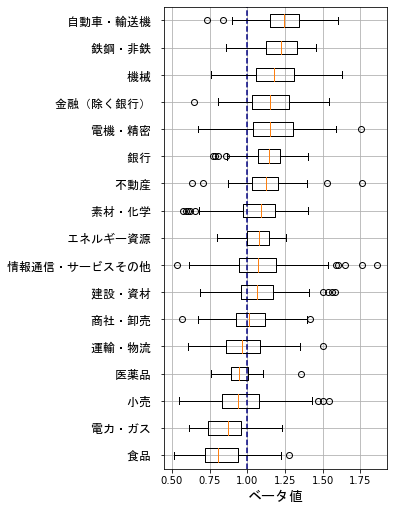

In [7]:
my_boxplot(data, "17業種区分", "adjusted_beta", by = "median")

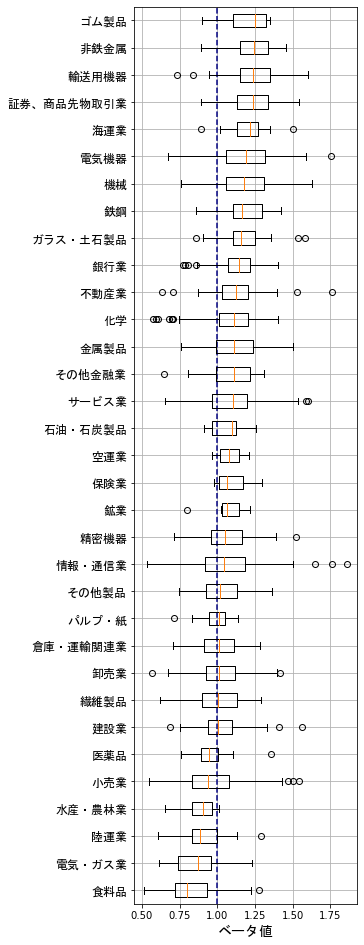

In [8]:
my_boxplot(data, "33業種区分", "adjusted_beta", by = "median")

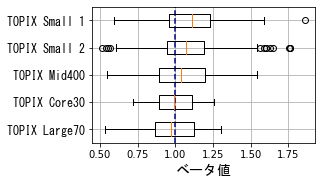

In [9]:
my_boxplot(data, "規模区分", "adjusted_beta", by = "median")

# 統計的検定


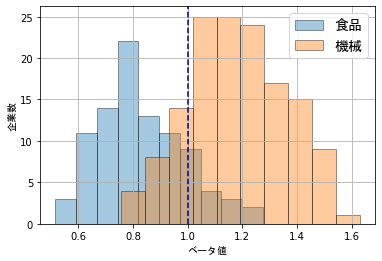

In [10]:
beta_list1 = data[data["17業種区分"] == "食品 "]["adjusted_beta"].values
beta_list2 = data[data["17業種区分"] == "機械 "]["adjusted_beta"].values

plt.hist(beta_list1, alpha = 0.4, label = "食品", bins = 10, ec = "black")
plt.hist(beta_list2, alpha = 0.4, label = "機械", bins = 10, ec = "black")
plt.xlabel("ベータ値", fontname = "MS Gothic")
plt.ylabel("企業数", fontname = "MS Gothic")
plt.axvline(x = 1.0, linestyle = "dashed", color = "navy")
#plt.vlines([1.0], ymin = 0.0, ymax = 25.0, colors = "navy", linestyles = "dashed")
plt.legend(prop = {"family": "MS Gothic", "size": 14})
plt.grid()


In [11]:
from scipy import stats
mu1 = beta_list1.mean()
sigma1 = beta_list1.std(ddof = 1)
stats.kstest(beta_list1, "norm", args = [mu1, sigma1])

mu2 = beta_list2.mean()
sigma2 = beta_list2.std(ddof = 1)
stats.kstest(beta_list2, "norm", args = [mu2, sigma2])

KstestResult(statistic=0.040358462777553505, pvalue=0.9676596417912894)

In [12]:
p_threshold = 0.05
for category in data["17業種区分"].unique():
    print(category, ":", sum(data["17業種区分"] == category))
    beta_list = data[data["17業種区分"] == category]["adjusted_beta"].values
    mu = beta_list.mean()
    sigma = beta_list.std(ddof = 1) # 不偏推定量
    p_value = stats.kstest(beta_list, "norm", args = [mu, sigma]).pvalue
    print(p_value)
    if p_value < p_threshold: # 棄却
        print("正規分布ではなさそう")
    else:
        print("正規分布ではないとはいえない")
    print("\r")

食品  : 92
0.5460846987451864
正規分布ではないとはいえない

商社・卸売  : 178
0.9398009426098043
正規分布ではないとはいえない

建設・資材  : 174
0.7557544715031188
正規分布ではないとはいえない

エネルギー資源  : 15
0.9833868861552407
正規分布ではないとはいえない

情報通信・サービスその他  : 507
0.22016903548828803
正規分布ではないとはいえない

機械  : 142
0.9676596417912894
正規分布ではないとはいえない

不動産  : 71
0.5837175631531903
正規分布ではないとはいえない

運輸・物流  : 79
0.6961552674060174
正規分布ではないとはいえない

小売  : 200
0.5221174769404301
正規分布ではないとはいえない

素材・化学  : 198
0.26794988409001264
正規分布ではないとはいえない

電機・精密  : 192
0.9505915489230699
正規分布ではないとはいえない

自動車・輸送機  : 70
0.6602128615677493
正規分布ではないとはいえない

医薬品  : 35
0.8148047624501503
正規分布ではないとはいえない

鉄鋼・非鉄  : 55
0.9490306387794577
正規分布ではないとはいえない

金融（除く銀行）  : 56
0.6058533852473051
正規分布ではないとはいえない

銀行  : 80
0.2504950232516714
正規分布ではないとはいえない

電力・ガス  : 22
0.8014697199371112
正規分布ではないとはいえない



In [13]:
data_chem = data[data["33業種区分"] == "化学"].copy()
data_chem.sort_values("adjusted_beta").to_excel("33業種区分_化学.xlsx")

In [19]:
data_chem.sort_values("adjusted_beta")[["会社名", "adjusted_beta"]]

,会社名,adjusted_beta
証券コード,,
4912,ライオン株式会社,0.572165
7947,株式会社エフピコ,0.595149
4929,株式会社アジュバンコスメジャパン,0.607378
4967,小林製薬株式会社,0.682488
8113,ユニ・チャーム株式会社,0.700802
...,...,...
4023,株式会社クレハ,1.334849
4410,ハリマ化成グループ株式会社,1.338306
4004,昭和電工株式会社,1.356951
